# import

In [1]:
import numpy as np
import dimod
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools  



def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [2]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

QPU Advantage2_prototype1.1 was selected.


# Functions and definitions

Need the following definitions

In [3]:
#array of A,B and the x and y shifts
Lx = 7; Ly = 7; #this is the max that can be done. 
#this is the plaquette values
array_AB = [['' for i in range(Ly)] for j in range(Lx)]
for ix in range(Lx):
    for iy in range(Ly):
        if ix%2 == 0:
            if iy%2 == 0:
                array_AB[ix][iy] = 'A'
            else:
                array_AB[ix][iy] = 'B'
        else:
            if iy%2 == 0:
                array_AB[ix][iy] = 'B'
            else:
                array_AB[ix][iy] = 'A'
array_AB = np.array(array_AB)

#array of A,B and the x and y shifts
#this is the plaquette values
array_shifts = np.empty((Lx, Ly,2))
for ix in range(Lx):
    for iy in range(Ly):        
        array_shifts[ix, iy] = [4 - (ix%2)*7,4 - (iy%2)*7]


#####
#plotting the A/B sublattice structure
#####
ybond_qubit = np.ones((Lx, Ly+1))
xbond_qubit = np.ones((Lx+1, Ly))

In [4]:
#missing ancillas are fixed by hand in this embedding function

def plaquette_embedding_walternate(sublatt, parity, corner_top_left_indices, tuple_shift, weird_cells_horizontal_index):
    top_left_vertical = corner_top_left_indices[0]
    top_left_horizontal = corner_top_left_indices[1]
    shift_x = tuple_shift[0]
    shift_y = tuple_shift[1]

    plaquette_sites = [top_left_horizontal + 8, top_left_vertical + shift_x + 8, top_left_horizontal + 8 + shift_y, top_left_vertical + 8]
    ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
    ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
    J_dict = {}
    h_dict = {}
    missing_coupler = {}
    missing_qubits = {}

    J_couplers_even = [-4, 2, 1]
    J_couplers_odd = [-2,1, 1]

    #special cells
    #[[420, 69], [483, 230]]
    #weird_cells_horizontal_index = [69, 230]

    #problematic cells - can be fed in at function level
    #and then there are 2 types of embedding for each case:
    #   -whether corner_top_left_indices[1] not in problematic cells
    #   -wether it is in


    if corner_top_left_indices[1] not in weird_cells_horizontal_index:

        if sublatt == 'A':
            ancilla_sites = ancilla_sites_A
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 16]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 16)]
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 16, top_left_vertical + 16)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 16)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 16), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 16),
                (top_left_vertical + 16, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 16, top_left_horizontal + 8),
                (top_left_vertical + 16, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
        elif sublatt == 'B':
            ancilla_sites = ancilla_sites_B
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 24, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + 24 + shift_y, top_left_horizontal + 24), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal + 24, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 24),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 24, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal + 24)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 24, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 24, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})
    else:
        if sublatt == 'A':
            #this is an A sublattice, modified
            #initial ancilla structure
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal + 16, top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y, top_left_vertical + 24]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal + 16, top_left_vertical + 24]
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + 24)]
                #these are the J = 2
                edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8),
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x + 24, top_left_vertical + 24)]
                edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal + 16),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 24)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 24), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 16 + shift_y), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 24),
                (top_left_vertical + 24, top_left_horizontal + 16)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 16, top_left_vertical + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8), 
                (top_left_vertical + shift_x + 24, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
                (top_left_vertical + 24, top_left_horizontal + 8),
                (top_left_vertical + 24, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

        elif sublatt == 'B':
            #this is a B sublattice
            #ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
            #ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
            ancilla_sites = [top_left_horizontal, top_left_vertical + shift_x, top_left_horizontal + shift_y, top_left_vertical]
            all_sites = ancilla_sites + plaquette_sites
            if parity == 1:
                chain_sites = [top_left_horizontal, top_left_vertical]
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical)]
                edges_dominant = [(top_left_horizontal + shift_y, top_left_horizontal), 
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8),
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_vertical + shift_x, top_left_vertical)]
                edges_intra = [(top_left_horizontal, top_left_vertical + shift_x + 8),
                (top_left_vertical + shift_x + 8, top_left_vertical + 8),
                (top_left_vertical + 8, top_left_horizontal),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + 8 + shift_y, top_left_vertical)]

                all_edges = edges_chain + edges_dominant + edges_intra 
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_even[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_dominant:
                        jval = J_couplers_even[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_even[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})

                for i in all_sites:
                    if i in ancilla_sites:
                        if i in chain_sites:
                            if i in sampler.nodelist:
                                h_dict.update({i:-1})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-1})
                        else:
                            if i in sampler.nodelist:
                                h_dict.update({i:-2})
                            else:
                                #print("problem with ", i)
                                missing_qubits.update({i:-2})
                    elif i in plaquette_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
            elif parity == -1:
                #even embedding
                edges_chain = [(top_left_horizontal, top_left_vertical + shift_x), 
                (top_left_vertical + shift_x, top_left_horizontal + shift_y), 
                (top_left_horizontal + shift_y, top_left_vertical),
                (top_left_vertical, top_left_horizontal)]
                edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
                (top_left_horizontal + 8, top_left_vertical + 8),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
                (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
                (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
                (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

                edges_intra = [(top_left_horizontal, top_left_vertical + 8 + shift_x),
                (top_left_horizontal, top_left_vertical + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8), 
                (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
                (top_left_horizontal + shift_y, top_left_vertical + shift_x + 8), 
                (top_left_horizontal + shift_y, top_left_vertical + 8),
                (top_left_vertical, top_left_horizontal + 8),
                (top_left_vertical, top_left_horizontal + 8 + shift_y)]

                all_edges = edges_chain + edges_intra + edges_inter
                for e in all_edges:
                    if e in edges_chain:
                        jval = J_couplers_odd[0]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_intra:
                        jval = J_couplers_odd[1]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                    elif e in edges_inter:
                        jval = J_couplers_odd[2]
                        if e in sampler.edgelist:
                            J_dict.update({e:jval})
                        elif Reverse(e) in sampler.edgelist:
                            J_dict.update({Reverse(e):jval})
                        else:
                            #print("problem with ", e)
                            missing_coupler.update({e:jval})
                
                for i in all_sites:
                    if i not in sampler.nodelist:
                        #print("problem with ", i)
                        missing_qubits.update({i:0})
                    else:
                        h_dict.update({i:0})

    return h_dict, J_dict, plaquette_sites, ancilla_sites, missing_coupler, missing_qubits


# Embedding


In [32]:
def random_gauge_embedding(jbox_values):

    #J grid
    #all ones or minus ones
    Lx = jbox_values.shape[0]; Ly = jbox_values.shape[1]; #7 is the largest size available
    base_tuple = np.array([320, 32])
    cell_shifts_unit = np.array([0,4])
    #problem_cells = [69, 230]
    problem_cells = [69, 230, 33, 226, 227, 160, 224, 70]
    #this could be done automatically by identifying the "cells" that have missing couplers.

    cell_shifts = []
    for i in range(5):
        cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
    cell_shifts = np.array(cell_shifts).flatten()

    complete_h_dict = {}
    complete_J_dict = {}
    plaquette_by_plaquette = {}
    missing_coup_all = []
    missing_qub_all = []
    all_plaquettes = []
    all_ancillas = []
    list_all_missing_qub = []
    all_plot_qubits = []

    for ix in range(Lx):
        for iy in range(Ly):
            translation_vector = [ix,iy] #
            starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
            #print("cell:", starting_tuple)

            J_box = jbox_values[ix,iy]
            sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
            #print(sublattice)
            shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
            shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
            #print(shift_x, shift_y)
            # h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))
            #[69, 230]
            h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding_walternate(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y), problem_cells)

            plaquette_by_plaquette.update({tuple(translation_vector):plaquette})
            all_plaquettes.append(plaquette)
            all_ancillas.append(ancillas)
            missing_coup_all.append(missing_coup)
            missing_qub_all.append(missing_qub)
            for node in list(missing_qub):
                list_all_missing_qub.append(node)

            #J_dict is simply updated, it never interferes with itself
            complete_J_dict.update(J_dict)
            #h_dict has to be added to each h if there is doubling
            for key in h_dict.keys():
                if key in complete_h_dict:
                    complete_h_dict[key] += h_dict[key]
                else:
                    complete_h_dict.update({key:h_dict[key]})

            # print("missing couplers")
            # print(missing_coup)
            # print("missing qubits")
            # print(missing_qub)

            for p in range(4):
                all_plot_qubits.append(starting_tuple[0] + 8*p)
                all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
                all_plot_qubits.append(starting_tuple[1] + 8*p)
                all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)

    #massage the missing_coups and missing_qubs lists
    dict_missing_coups = {}
    for item in missing_coup_all:
        if len(item) > 0:
            dict_missing_coups.update(item)

    dict_missing_qubs = {}
    for item in missing_qub_all:
        if len(item) > 0:
            for key in item.keys():
                if key in dict_missing_qubs:
                    dict_missing_qubs[key] += item[key]
                else:
                    dict_missing_qubs.update({key:item[key]})


    # print("missing couplers")
    # print(dict_missing_coups)
    # print("missing qubits")
    # print(dict_missing_qubs)

    #Qubit replacement dict:
    qubit_replacements = {}
    qubit_replacements.update({328:[344,32]}) #qubit
    qubit_replacements.update({458:[477,478]}) #qubit
    qubit_replacements.update({461:[461,134]}) #change qubit
    qubit_replacements.update({462:[462,166]}) #change qubit
    qubit_replacements.update({463:[455,226]}) #qubit


    fixed_qubits = [key for key in qubit_replacements.keys()]

    # print('done with replacements')

    #create chains
    adding_chains = {}
    #2 chains have a -4 constraint, 
    for chain in qubit_replacements.values():
        #K = -len(chain)
        K = -2
        for i in range(len(chain) - 1):
            edge = (chain[i], chain[i+1])
            if edge in sampler.edgelist:
                adding_chains.update({edge:K})
            elif Reverse(edge) in sampler.edgelist:
                adding_chains.update({Reverse(edge):K})
            else:
                print("problem with ", edge)
    # print('done with the list of chains to fix missing sites')
    # print(adding_chains)

    new_h_values = {}
    for key in fixed_qubits:
        if key in complete_h_dict:
            #print(complete_h_dict[ind])
            h_value = complete_h_dict[key]
        else:
            #print(dict_missing_qubs[ind])
            h_value = dict_missing_qubs[key]
        chain_sites = qubit_replacements[key]
        Nchain = len(chain_sites)
        for site in chain_sites:
            new_h_values.update({site:h_value/Nchain})

    # print('done with new h values')
    # print(new_h_values)

    #adding the new couplers to the chains you've created

    adding_new_couplers = {}
    unfixed_couplers = {}
    for coup in dict_missing_coups.keys():
        value = dict_missing_coups[coup]
        #print(coup)
        if coup[0] in qubit_replacements:
            listA = qubit_replacements[coup[0]]
            #print(listA)
        else:
            listA = [coup[0]]
        if coup[1] in qubit_replacements:
            listB = qubit_replacements[coup[1]]
        else:
            listB = [coup[1]]
        #print(listA)
        chain_sites = [(listA), (listB)]

        #create list of possible edges
        possible_edges = list(itertools.product(listA, listB))
        new_bonds = np.zeros(len(possible_edges))
        #print(possible_edges)
        count = 0
        for edge in possible_edges:
            if edge in sampler.edgelist:
                adding_new_couplers.update({edge:value})
                new_bonds[count] = 1
            elif Reverse(edge) in sampler.edgelist:
                adding_new_couplers.update({Reverse(edge):value})
                new_bonds[count] = 1
            count +=1

        if sum(new_bonds) == 0.0 :
            #print(coup)
            unfixed_couplers.update({coup:value})
    # print('done with new couplers')
    # print(adding_new_couplers)


    ### putting the embedding together

    new_fixed_J_dict = complete_J_dict
    new_fixed_J_dict.update(adding_new_couplers)
    new_fixed_J_dict.update(adding_chains)

    new_fixed_h_dict = complete_h_dict
    new_fixed_h_dict.update(new_h_values)

    all_ancillas = np.array(all_ancillas).flatten()

    # print('done with new embedding')

    all_plaquettes = np.array(all_plaquettes).flatten()
    all_plaquettes_mod = all_plaquettes
    for i in range(len(all_plaquettes)):
        if all_plaquettes[i] in qubit_replacements:
            all_plaquettes_mod[i] = qubit_replacements[all_plaquettes[i]][0]

    return new_fixed_J_dict, new_fixed_h_dict, all_ancillas, unfixed_couplers, all_plaquettes_mod


missing couplers
{(52, 328): 2, (332, 328): 1, (328, 48): 1, (154, 458): 1, (158, 458): 1, (138, 458): 1, (142, 458): 1, (458, 461): 1, (182, 458): 2, (462, 458): 1, (458, 178): 1, (242, 463): 1, (246, 463): 1, (234, 463): 1, (238, 463): 1, (463, 459): 1}
missing qubits
{328: -1, 458: -1, 463: 0}
done with replacements
done with the list of chains to fix missing sites
{(32, 344): -2, (477, 478): -2, (134, 461): -2, (166, 462): -2, (226, 455): -2}
done with new h values
{344: -0.5, 32: -0.5, 477: -0.5, 478: -0.5, 461: -0.5, 134: -0.5, 462: -1.0, 166: -1.0, 455: 0.0, 226: 0.0}
done with new couplers
{(52, 344): 2, (32, 332): 1, (48, 344): 1, (154, 477): 1, (158, 477): 1, (138, 477): 1, (142, 477): 1, (134, 477): 1, (182, 478): 2, (166, 478): 1, (178, 478): 1, (242, 455): 1, (246, 455): 1, (234, 455): 1, (238, 455): 1, (226, 459): 1}
done with new embedding


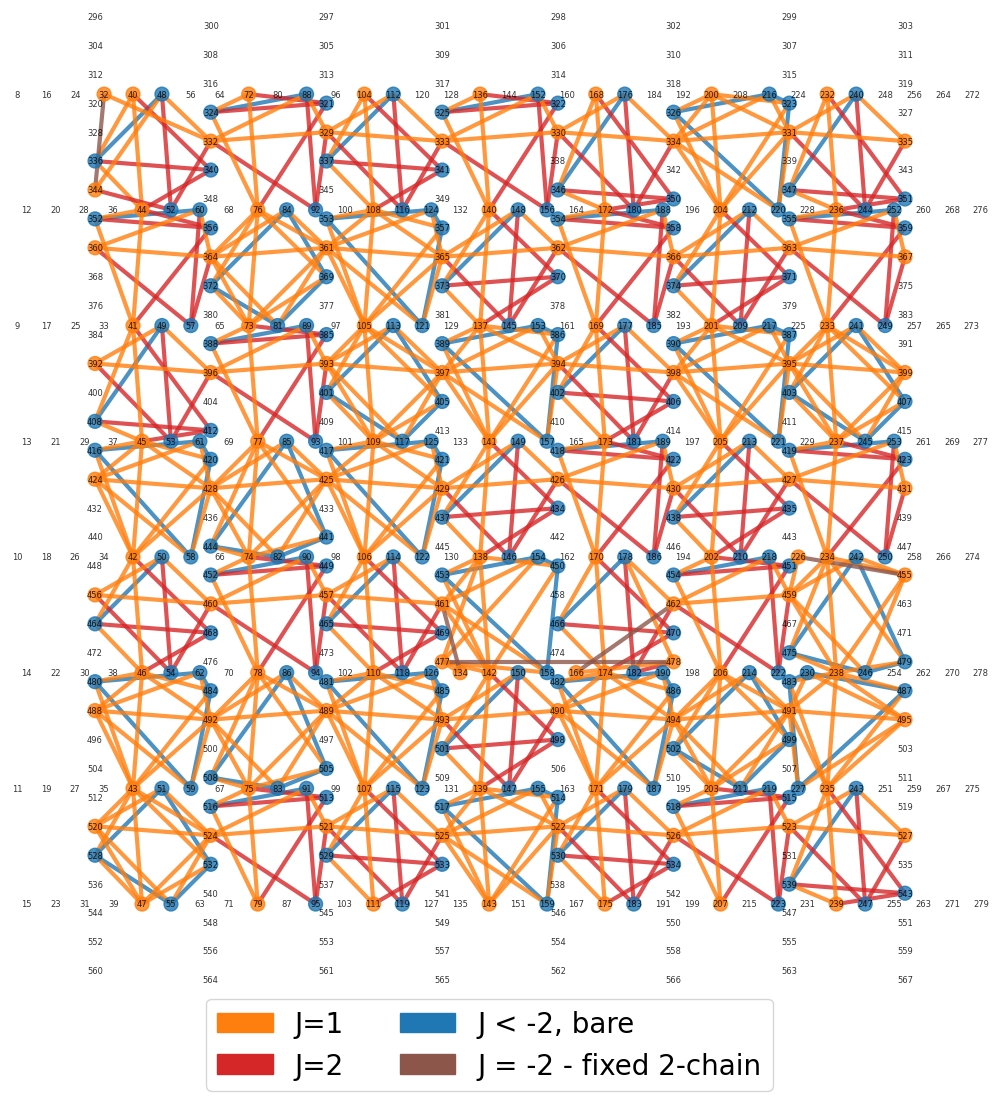

In [29]:
#
# jbox_values = np.ones((Lx,Ly)) #this is an all J_box = 1 experiment - each cell's parity should be -1
jbox_values = 1 - 2*np.random.randint(0, 2, (7, 7)) #random array of J = +1 or -1

new_fixed_J_dict, new_fixed_h_dict, all_ancillas, unfixed_couplers, all_plaquettes_mod = random_gauge_embedding(jbox_values)

edges_draw = [key for key in new_fixed_J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if new_fixed_J_dict[ed] < 0:
        if ed[0] in all_ancillas:
            edge_colors.append(all_colors[0])
        else:
            edge_colors.append(all_colors[5])
    elif new_fixed_J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif new_fixed_J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

for ed in unfixed_couplers.keys():
    edges_draw.append(ed)
    edge_colors.append('#000000')

node_colors = []
all_plot_qubits = [key for key in new_fixed_h_dict.keys()]
for site in all_plot_qubits:
    color = all_colors[1]
    if site in all_ancillas:
        color = all_colors[0]
    node_colors.append(color)

G = dnx.zephyr_graph(4)
plt.ion()
fig = plt.figure(figsize=(10,10))
plt.axis("off")
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 100, 
edgelist = edges_draw, with_labels = True, node_color = node_colors, 
font_size = 6, alpha = 0.8, edge_color = edge_colors)

legend_elements = [Patch(facecolor=all_colors[1], edgecolor=all_colors[1],
                         label='J=1'), 
                    Patch(facecolor=all_colors[3], edgecolor=all_colors[3],
                         label='J=2'), 
                    Patch(facecolor=all_colors[0], edgecolor=all_colors[0],
                         label='J < -2, bare'), 
                    Patch(facecolor=all_colors[5], edgecolor=all_colors[5],
                         label='J = -2 - fixed 2-chain'), ]
plt.legend(handles=legend_elements, bbox_to_anchor=(0.2, -0.01), loc='upper left', borderaxespad=0, ncol=2, fontsize = 20)
plt.show()

**final embedding**

In [19]:
print(new_fixed_J_dict)
print(new_fixed_h_dict)

{(48, 340): -2, (52, 340): -2, (52, 336): -2, (48, 336): -2, (48, 332): 1, (40, 340): 1, (44, 340): 1, (52, 332): 1, (40, 336): 1, (44, 336): 1, (40, 332): 1, (44, 332): 1, (40, 44): 1, (60, 352): -4, (57, 60): 2, (57, 364): 2, (57, 360): 2, (44, 356): 2, (41, 356): 2, (352, 356): 2, (60, 364): 1, (360, 364): 1, (60, 360): 1, (44, 352): 1, (41, 44): 1, (41, 352): 1, (49, 412): -2, (53, 412): -2, (53, 408): -2, (49, 408): -2, (49, 396): 1, (49, 392): 1, (41, 412): 1, (45, 412): 1, (53, 396): 1, (53, 392): 1, (41, 408): 1, (45, 408): 1, (41, 396): 1, (41, 392): 1, (45, 396): 1, (45, 392): 1, (41, 45): 1, (392, 396): 1, (61, 416): -4, (58, 61): 2, (58, 428): 2, (58, 424): 2, (45, 420): 2, (42, 420): 2, (416, 420): 2, (61, 428): 1, (424, 428): 1, (61, 424): 1, (45, 416): 1, (42, 45): 1, (42, 416): 1, (50, 464): -4, (50, 54): 2, (54, 460): 2, (54, 456): 2, (42, 468): 2, (46, 468): 2, (464, 468): 2, (50, 460): 1, (456, 460): 1, (50, 456): 1, (42, 464): 1, (42, 46): 1, (46, 464): 1, (62, 484)

# Random gauge model constraint

Random $J_{\Box}$ array is done below. Because of finite array, a specific number of cells is chosen

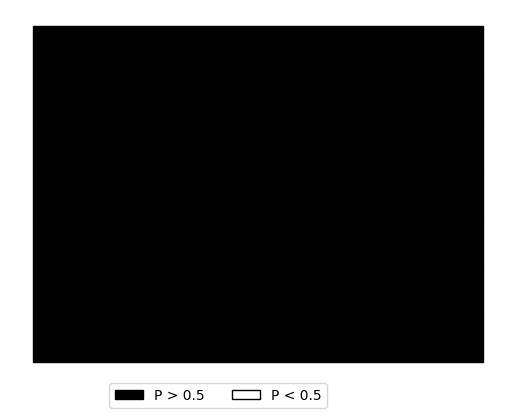

In [75]:
n = 0
chosen_plaquettes = np.random.choice(49, n, replace=False)
jbox_values = np.ones((7,7))
for cp in chosen_plaquettes:
    jbox_values[cp%7, (cp//7)] = -1

cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()


#tb = Table(ax, bbox = [0.0, 0.045, 1.0, 1.0])
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = jbox_values.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(jbox_values):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    if show_text:
        text_in = fmt % cell_val
    else:
        text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        text=text_in,
        loc="center",
        facecolor=cell_colors[color_code],
    )
    tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

ax.add_table(tb)
tb.set_fontsize(fontsize)

legend_elements = [Patch(facecolor='black', edgecolor='black',
                         label='P > 0.5'), 
                    Patch(facecolor='white', edgecolor='black',
                         label='P < 0.5')]

# Create the figure
#fig, ax = plt.subplots()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.2, -0.01), loc='upper left', borderaxespad=0, ncol=2)

In [12]:
# inv_temp_range = 1 / np.linspace(1, 50, 20)
inv_temp_range = np.linspace(0.01, 1, 23)
print(inv_temp_range)

[0.01  0.055 0.1   0.145 0.19  0.235 0.28  0.325 0.37  0.415 0.46  0.505
 0.55  0.595 0.64  0.685 0.73  0.775 0.82  0.865 0.91  0.955 1.   ]


# tuning the temperature

In [97]:
#saving
filepath = "./data/"

#anneal params
Nreads = 200
anneal_time = 10
Nrep = 1
inv_temp = 1
n = 49
inv_temp_range = 1 / np.linspace(1, 10, 20)

for inv_temp in inv_temp_range:

    for rep in range(Nrep):
        #random J_box config
        chosen_plaquettes = np.random.choice(49, n, replace=False)
        jbox_values = np.ones((7,7))
        for cp in chosen_plaquettes:
            jbox_values[cp%7, (cp//7)] = -1
        #density for J_box
        rho = n/49

        #new embedding
        new_fixed_J_dict, new_fixed_h_dict, all_ancillas, unfixed_couplers, all_plaquettes_mod = random_gauge_embedding(jbox_values)

        #change couplings because of inverse temperature
        J_mod_dict = {}
        for key in new_fixed_J_dict.keys():
            if new_fixed_J_dict[key] < -1.2:
                J_mod_dict.update({key:new_fixed_J_dict[key]})
            else:
                J_mod_dict.update({key:new_fixed_J_dict[key]*inv_temp})
        h_mod_dict = {}
        for key in new_fixed_h_dict.keys():
            h_mod_dict.update({key:new_fixed_h_dict[key]*inv_temp})


        response = sampler.sample_ising(h = h_mod_dict, J=J_mod_dict,
                                                    num_reads=Nreads,
                                                    annealing_time=anneal_time,
                                                    answer_mode="raw")

        final_nodes=sorted(list(h_mod_dict.keys()))
        time = response.info['timing']['qpu_access_time']
        resp = response.record 
        variables = response.variables   
        #save the response
        paramsarray = set_params_array({
                        'beta': inv_temp,
                        'rho': rho,
                        'Nreads': Nreads,
                        'shim-or-measure' : 'measure',
                        'anneal-time' : anneal_time,
                        'runtime' : time,
                        'answer_mode' :'raw',
                        'id' : response.info['problem_id']
                    })

        folder = Path("./data/raw/" + "/" + "n=" + str(n) + "/" + "beta=" + str(inv_temp))
        folder.mkdir(parents=True, exist_ok=True)
        Name = 'forward_anneal_sol_' + str(rep)
        filepath = Path(folder, Name)

        #save the response
        resp = response.record
        np.savez(
        filepath,
        resp=resp,
        paramsarray=paramsarray,
        final_nodes = final_nodes,
        variables = variables,
        unfixed_couplers = unfixed_couplers,
        all_ancillas = all_ancillas,
        all_plaquettes_mod = all_plaquettes_mod,
        jbox_values = jbox_values
        )

        print('done! beta = {:.2f}, rep = {:.2f}'.format(inv_temp, rep))



done! beta = 1.00, rep = 0.00
done! beta = 0.68, rep = 0.00
done! beta = 0.51, rep = 0.00
done! beta = 0.41, rep = 0.00
done! beta = 0.35, rep = 0.00
done! beta = 0.30, rep = 0.00
done! beta = 0.26, rep = 0.00
done! beta = 0.23, rep = 0.00
done! beta = 0.21, rep = 0.00
done! beta = 0.19, rep = 0.00
done! beta = 0.17, rep = 0.00
done! beta = 0.16, rep = 0.00
done! beta = 0.15, rep = 0.00
done! beta = 0.14, rep = 0.00
done! beta = 0.13, rep = 0.00
done! beta = 0.12, rep = 0.00
done! beta = 0.12, rep = 0.00
done! beta = 0.11, rep = 0.00
done! beta = 0.10, rep = 0.00
done! beta = 0.10, rep = 0.00


The definition of a new plaquette measurement based on the majority rule for the chains.

In [18]:
#new plaquettes
plaq_variable_index_mod = []

single_qubits_mag = np.unique(all_plaquettes_mod)

#does not work yet, only works after a run has been done and an embedding is defined.
for i in range(int(len(all_plaquettes_mod)/4)):
    qubit_indices = all_plaquettes_mod[4*i:(4*i+4)]
    single_plaquette = []
    for k in range(4):
        where_is_it = np.where(np.array(response.variables) == qubit_indices[k])[0]
        if len(where_is_it) > 0:
            single_plaquette.append(where_is_it[0])
    if len(single_plaquette) != 4:
        print("woops")
    plaq_variable_index_mod.append(np.array(single_plaquette))
#print(plaq_variable_index_mod)

indices_for_mag = []
for i in range(len(single_qubits_mag)):
    where_is_it = np.where(np.array(response.variables) == single_qubits_mag[i])[0]
    if len(where_is_it) > 0:
        indices_for_mag.append(where_is_it[0])

#unit cells in the same order as the plaq_variable_index
unit_cell_after = [key for key in list(plaquette_by_plaquette)]
all_avg = np.zeros((Lx,Ly))
all_avg_min = np.zeros((Lx,Ly))
#min_ene = response.record[0][1]
min_ene = np.min([response.record[i][1] for i in range(len(response.record))])
count = 0
mag_av = 0
mag_av_2 = 0
for resp in response.record:
    if resp[1] == min_ene:
        count += 1
        for k in range(len(plaq_variable_index_mod)):
            all_avg_min[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])
    for k in range(len(plaq_variable_index_mod)):
        all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])

    for i in range(len(indices_for_mag)):
        mag_av += np.sum(resp[0][indices_for_mag[i]])
        mag_av_2 += np.sum(resp[0][indices_for_mag[i]]**2)

print("percentage of samples in lowest energy state: ", 100*count/len(response.record))
print("avg value of Sum(P)/N for the lowest energy states: ", np.sum(all_avg_min/count)/(7*7))
print("avg value of Sum(P)/N for all states: ", np.sum(all_avg/len(response.record))/(7*7))
print("avg magnetization for all states: ", mag_av/len(response.record)/(7*7*4))

percentage of samples in lowest energy state:  0.5
avg value of Sum(P)/N for the lowest energy states:  0.10204081632653061
avg value of Sum(P)/N for all states:  0.007142857142857144
avg magnetization for all states:  0.06821428571428571


/tmp/ipykernel_24647/1323171146.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


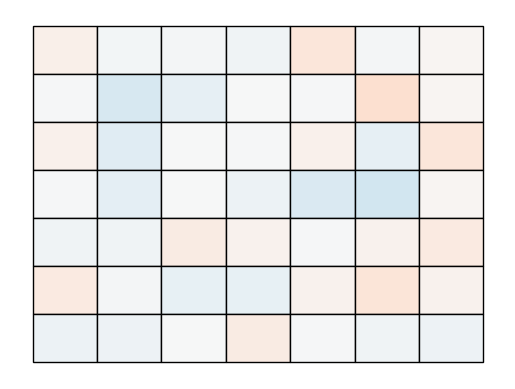

In [19]:
cmap = cm.get_cmap('RdBu')
#norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

#this is the plaquette values
ary = np.transpose(all_avg/len(response.record)) #plot over all obtained states
# ary = np.transpose(all_avg_min/count) #plot over only the lowest energy states
cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    # if show_text:
    #     text_in = fmt % cell_val
    # else:
    #     text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        #text=text_in,
        loc="center",
        facecolor=cmap((cell_val + 1)/2),
    )
    #print(cmap(cell_val))
    #tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

tb.set_fontsize(fontsize)
ax.add_table(tb)


/tmp/ipykernel_490/2996533790.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')
/tmp/ipykernel_490/2996533790.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


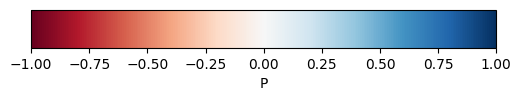

In [49]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('P')
fig.show()

# evaluation for full run

each rho
1000 reads per rep - this is 100 ms
20 reps - 2 s
23 temperatures - 46 seconds

12 rho values: approx. 9 minutes

In [17]:
np.floor(np.linspace(0, 49, 12))

array([ 0.,  4.,  8., 13., 17., 22., 26., 31., 35., 40., 44., 49.])